# Synchronization

Once we've converted incoming data to baseband, we need to find the symbols in this stream of data.

There are a lot of different ways of doing this, such as early/late gate synchronizers, costas loops, etc.

Instead, I re-invented (I'm sure) some other method I don't know the name of...

In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import fft, fftfreq
import matplotlib.pyplot as plt

import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from alldigitalradio.shiftregisters import prbs9
from alldigitalradio.io.numpy import make_callable, take_n
from alldigitalradio.sync import Matcher, CorrelativeSynchronizer

In my case for bluetooth (advertising) packets, there's a fairly long preamble that we're looking for and once we find it, there's only a few hundred bits (typically) left in the packet. This allows me to skip continuous closed-loop feedback to realign symbols because the symbol clock would have to be _way_ off in order for us to lose sync.

But let's first create a "needle" and a "haystack" from a standard psuedorandom binary sequence

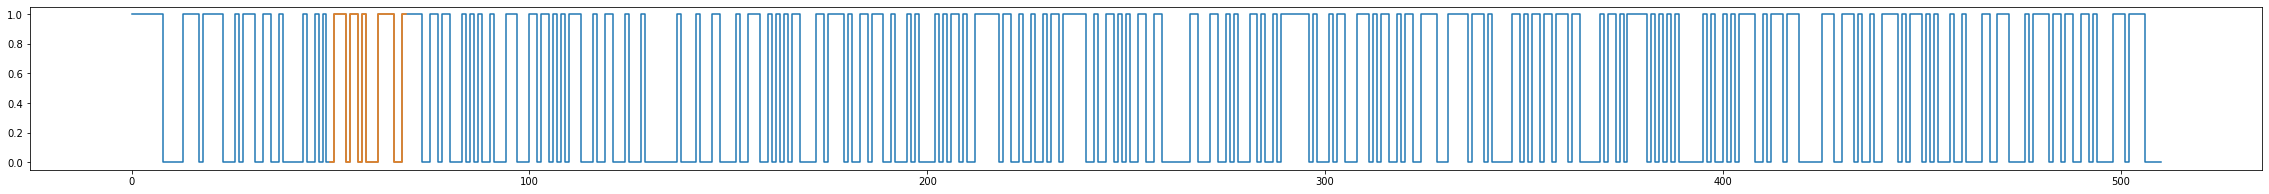

In [2]:
haystack = prbs9()
plt.figure(figsize=(40,3))
plt.step(range(len(haystack)), haystack)

# Take a subpart out which we'll use our Synchronization logic to "find" again
needle = haystack[50:70]
plt.step(range(50, 70), needle)

# Now, if we only had one sample per symbol... alignment would be easy! So let's make it a bit harder and have 10 samples per symbol
haystack = np.repeat(haystack, 10)

Now let's set up a `Matcher` which is a module that has a `match` output signal that goes high when it find the specified pattern in a (chronological) stream of bits)

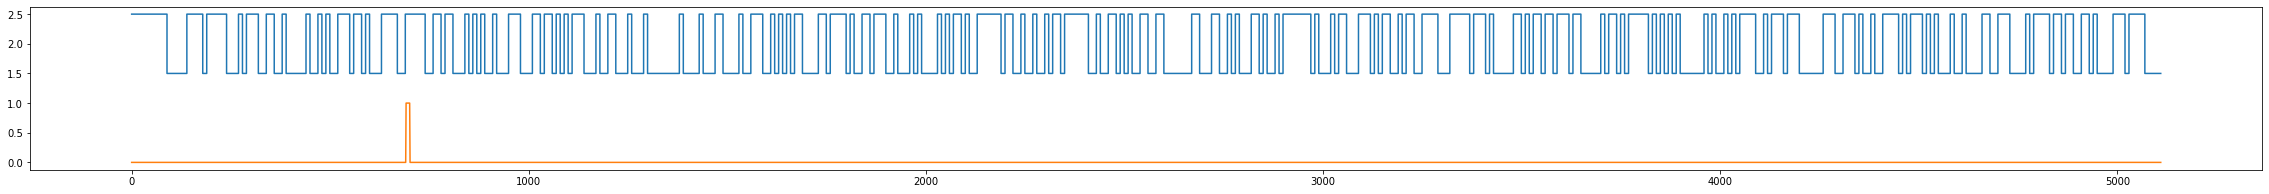

In [3]:
# Note that (at the moment, the matcher interval is the number of samples between, not from one to ther other)
matcher = make_callable(Matcher(list(map(int, needle)), 9))

plt.figure(figsize=(40,3))
plt.step(range(len(haystack)), haystack + 1.5)
plt.plot(np.array([matcher(int(b))[0] for b in haystack]))

As we expect, this goes high at the end of the occurrence of the needle in the haystack (because it needs to see all the data before it matches)

Next, let's demonstrate a `CorrelativeSynchronizer` that uses this matcher combined with a state machine to strobe out when the next state in the pipeline should sample a bit.

(650.0, 800.0)

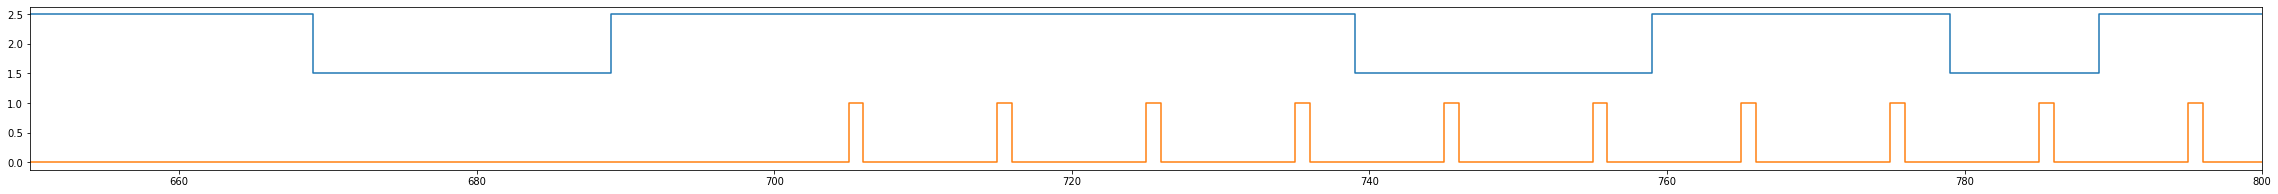

In [4]:
sync = make_callable(CorrelativeSynchronizer(list(map(int, needle)), 10))

plt.figure(figsize=(40,3))
plt.step(range(len(haystack)), haystack + 1.5)

samples = np.array([sync(int(b)) for b in haystack])[1:]
plt.step(range(len(samples)), samples)

# Zoom into right as we've found the match
plt.gca().set_xlim(650, 800)

Thsi is zoomed in a bit, but as you can see once it finds a match:
    
1. It starts a counter until the match is lost
2. Once the match is lost it sets the counter as if it were halfway through the symbol.
3. The counter counts contiuously and resets to zero and goes high when samples_per_symbol have been counter
4. If the external reset goes high it goes back to matching (not shown here)